## Create a multi-temperature BB SED for the DT
In this notebook I try to address the question: how do we define a multi-temperature Black Body for the DT?    
A range of temperature for the dust torus is given in pag. 152 and Figure 7 of
https://ui.adsabs.harvard.edu/abs/2008ApJ...685..147N/abstract

In [1]:
import numpy as np
import astropy.units as u
from astropy.coordinates import Distance
from astropy.modeling.models import BlackBody
from agnpy.utils.math import axes_reshaper
from agnpy.targets import RingDustTorus
import matplotlib.pyplot as plt

In [2]:
# Nenkova 2008 formulas for minimum and maximum temperature
def T_min(L_disk, r):
    L_45 = (L_disk / (10**45 * u.Unit("erg s-1"))).to_value("")
    R_d = 0.4 * (L_45)**(1/2) * u.pc
    rho = (r / R_d).to_value("")
    return 400 * (1 / rho)**(0.42) * u.K

def T_max(L_disk, r):
    L_45 = (L_disk / (10**45 * u.Unit("erg s-1"))).to_value("")
    R_d = 0.4 * (L_45)**(1/2) * u.pc
    rho = (r / R_d).to_value("")
    return np.piecewise(
        rho, 
        [rho <= 9, rho > 9], 
        [lambda rho: 1500 * (1 / rho)**(0.39), lambda rho: 640 * (9 / rho)**(0.45)]
    ) * u.K

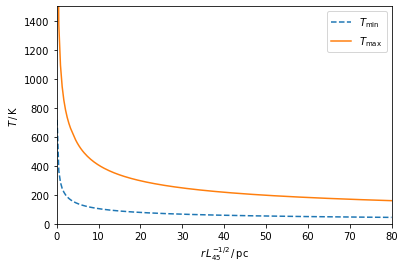

In [3]:
# let us recreate Figure 7 of the reference
r = np.linspace(0.1, 80, 200) * u.pc
L_disk = 1e45 * u.Unit("erg s-1")

L_45 = (L_disk / (10**45 * u.Unit("erg s-1"))).to_value("")
x = r / (L_45)**(1/2)
plt.plot(x, T_min(L_disk, r), ls="--", label=r"$T_{\rm min}$")
plt.plot(x, T_max(L_disk, r), ls="-", label=r"$T_{\rm max}$")
plt.xlim([0, 80])
plt.ylim([0, 1500])
plt.xlabel(r"$r\,L_{45}^{-1/2}\,/\,{\rm pc}$")
plt.ylabel(r"$T\,/\,{\rm K}$")
plt.legend()
plt.show()

Let us see where the temperature and radius (computed as the sublimation radius) normally used in agnpy fall

In [4]:
L_disk = 1e46 * u.Unit("erg s-1")
dt = RingDustTorus(L_disk, 0.2, 1000 * u.K)
print(dt.R_dt)

1.1067971810589327e+19 cm


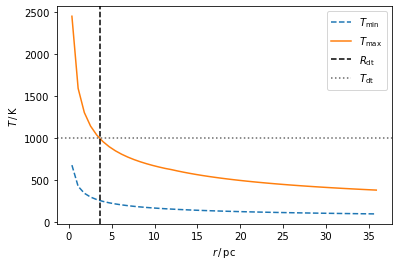

In [5]:
# consider a small range of distances
r = np.linspace(1e-1, 1e1) * dt.R_dt
plt.plot(r.to("pc"), T_min(L_disk, r), ls="--", label=r"$T_{\rm min}$")
plt.plot(r.to("pc"), T_max(L_disk, r), ls="-", label=r"$T_{\rm max}$")
plt.axvline(dt.R_dt.to_value("pc"), ls="--", color="k", label=r"$R_{\rm dt}$")
plt.axhline(dt.T_dt.to_value("K"), ls=":", color="dimgray", label=r"$T_{\rm dt}$")
plt.xlabel(r"$r\,/\,{\rm pc}$")
plt.ylabel(r"$T\,/\,{\rm K}$")
plt.legend()
plt.show()

So the value used by Nenkova et al. for the sublimation radius (that we assume to be the radius of the DT ring) actually falls on the curve of the maximum temperature. In other words, fixed the temperature, the radius of the Ring Dust Torus in Nenkova et al. (and in agnpy) is the radius for which that temperature is the maximum temperature.

### multi-temperature DT SEDs

Let us use now the full range of temperature from $T_{\rm min}$ to $T_{\rm max}$ to build a multi-temperature BB and let us confront it with the one implemented in agnpy.

In [6]:
def evaluate_multi_T_bb_norm_sed(nu, z, L_disk, csi_dt, R_dt, d_L, n_bb = 40):
    """Evaluate a normalised, multi-temperature black body SED for the DT"""
    _T_min = T_min(L_disk, R_dt)
    _T_max = T_max(L_disk, R_dt)
    print(f"evaluating BBs SEDs between T_min = {_T_min:.2e} and T_max = {_T_max:.2e}")
    T = np.linspace(T_min(L_disk, R_dt), T_max(L_disk, R_dt), n_bb)
    _T, _nu = axes_reshaper(T, nu)
    _I_nu = BlackBody().evaluate(_nu, _T, scale=1)
    # sum over all the temperature (just stack the I_nu spectra)
    I_nu =  np.sum(_I_nu, axis=0)
    # we assume the BB are emitted all at the same distance
    prefactor = np.pi * np.power((R_dt / d_L).to_value(""), 2) * u.sr
    sed_dt = (prefactor * nu * I_nu).to("erg cm-2 s-1")
    # renormalise
    L = (np.trapz(sed_dt / nu, nu) * 4 * np.pi * d_L ** 2).to("erg s-1")
    L_dt = L_disk * csi_dt
    norm = (L_dt / L).to_value("")
    return norm * sed_dt

evaluating BBs SEDs between T_min = 4.41e+02 K and T_max = 1.64e+03 K


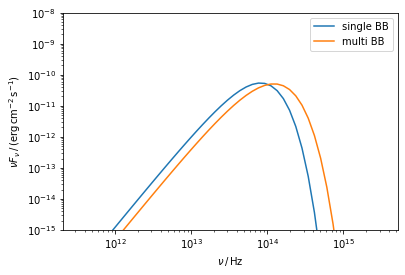

In [7]:
# general parameters
lambs = np.logspace(np.log10(0.1), np.log10(1000)) * u.um
nu = np.flip(lambs.to("Hz", equivalencies=u.spectral()))
z = 0.1
d_L = Distance(z=z).to("cm")

# let us define a new DT this time with a radius different than the sublimation radius
L_disk = 1e46 * u.Unit("erg s-1")
dt = RingDustTorus(L_disk, 0.2, 1000 * u.K, 1 * u.pc)

# let us compare the two SEDs (single- and multi- black body)
multi_bb_sed = evaluate_multi_T_bb_norm_sed(
    nu, z, dt.L_disk, dt.xi_dt, dt.R_dt, d_L
)
plt.loglog(nu, dt.sed_flux(nu, z), label="single BB")
plt.loglog(nu, multi_bb_sed, label="multi BB")
plt.ylim([1e-15, 1e-8])
plt.xlabel(r"$\nu\,/\,{\rm Hz}$")
plt.ylabel(r"$\nu F_{\nu}\,/\,({\rm erg}\,{\rm cm}^{-2}\,{\rm s}^{-1})$")
plt.legend()
plt.show()